In [229]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from scipy.spatial.distance import cdist, euclidean
from tqdm import tqdm

# Loading data

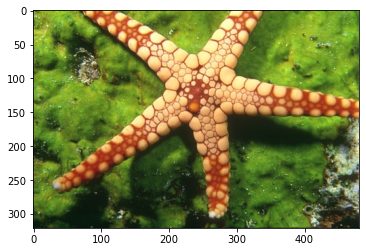

In [55]:
img = cv2.imread('star.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255
plt.imshow(img)
plt.show()

In [122]:
def normalize(X):
    return (X - X.mean(0)) / X.std(0)

In [123]:
X_color = img.reshape(-1, 3).copy()
color_mean, color_std = X_color.mean(0), X_color.std(0)
X_color = normalize(X_color)
# X_color = pd.DataFrame(X_color, columns=['R', 'G', 'B'])

indices = np.indices(img.shape[:-1]).transpose(1, 2, 0).reshape(-1, 2)
indices = normalize(indices)
# indices = pd.DataFrame(indices, columns=['x', 'y'])

# X_indices = pd.concat([X_color, indices], axis=1)
X_indices = np.concatenate([X_color, indices], axis=1)

# Implementing $k$-Means

In [197]:
def k_means(X, k):
    """
    X - the data for clustering, a dataframe of shape (N, d)
    k - the number of clusters
    
    output - the resulting clustering, a series of shape (N, )
    """
    N = X.shape[0]
    old_assignments = np.zeros(N)
    rand_ix = np.random.choice(N, k)
    centroids = X[rand_ix]
    changed = True
    with tqdm() as pbar:
        while changed:
            pbar.update()
            changed = False
            distances = cdist(X, centroids)
            assignments = np.argmin(distances, 1)
            changed = not np.array_equal(old_assignments, assignments)
            old_assignments = assignments
            
            mask_matrix = np.zeros((N, k))
            mask_matrix[np.arange(N), assignments] = 1
            centroids = mask_matrix.T @ X / np.bincount(assignments).reshape(-1, 1)
    return assignments, centroids

# Presenting Performance

## On color only

35it [00:00, 97.25it/s] 


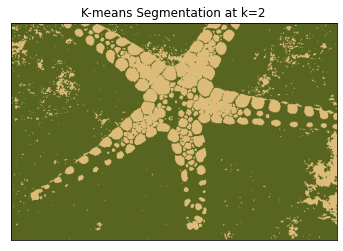

16it [00:00, 71.22it/s]


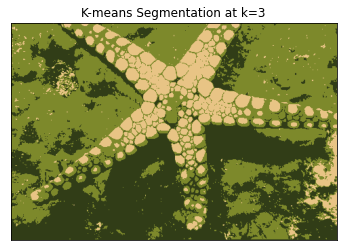

60it [00:00, 66.61it/s]


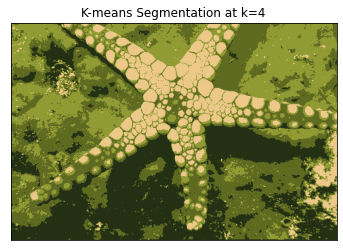

21it [00:00, 55.26it/s]


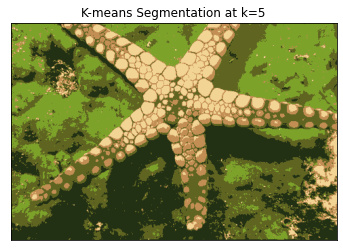

32it [00:00, 46.08it/s]


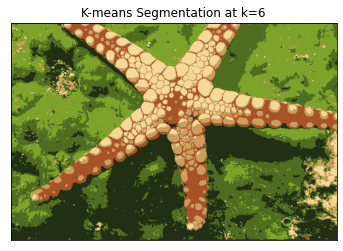

43it [00:00, 44.65it/s]


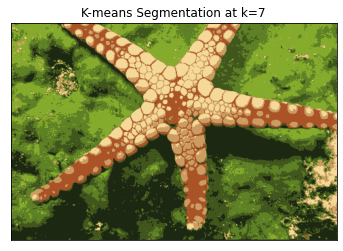

35it [00:00, 40.10it/s]


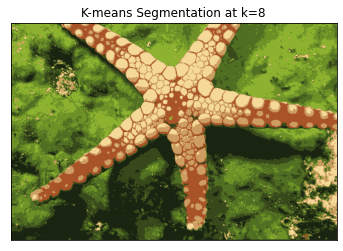

72it [00:02, 34.66it/s]


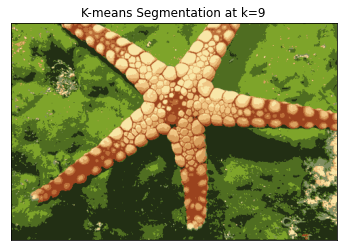

46it [00:01, 35.25it/s]


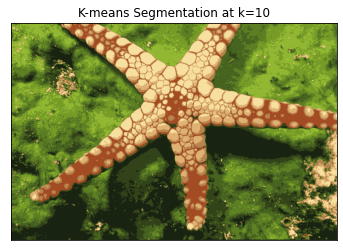

In [199]:
for k in range(2, 11):
    assignments, centroids = k_means(X_color, k)
    centroids = centroids * color_std + color_mean
    segmentation = np.zeros((assignments.shape[0], 3))
    for i in range(k):
        segmentation[assignments == i] = centroids[i]
    segmentation = segmentation.reshape(*img.shape[:-1], 3)
    plt.imshow(segmentation)
    plt.title(f'K-means Segmentation at k={k}')
    plt.xticks([])
    plt.yticks([])
    plt.show()

## On color and location

26it [00:00, 81.41it/s] 


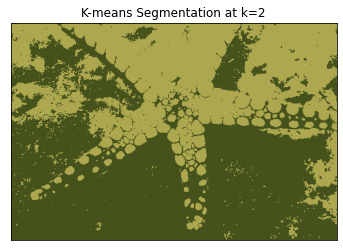

22it [00:00, 52.89it/s]


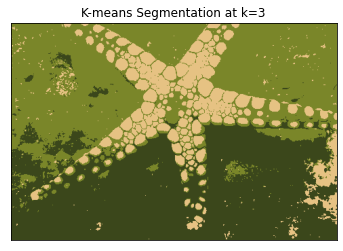

26it [00:00, 68.90it/s]


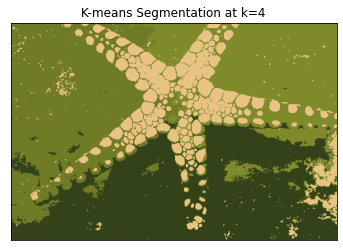

25it [00:00, 54.80it/s]


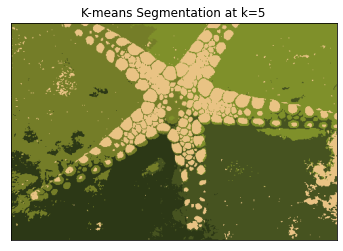

29it [00:00, 48.52it/s]


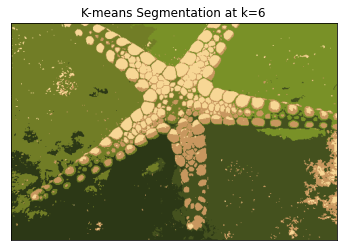

39it [00:01, 37.35it/s]


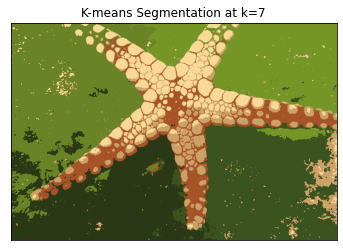

48it [00:01, 37.63it/s]


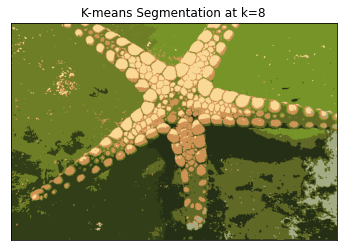

62it [00:01, 34.86it/s]


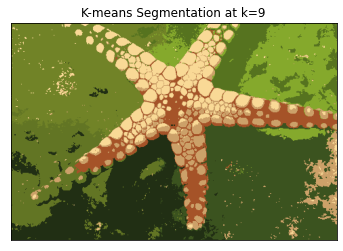

83it [00:02, 31.16it/s]


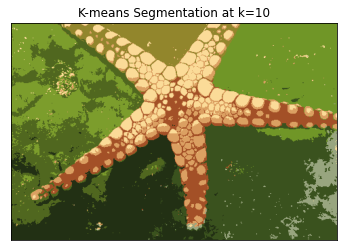

49it [00:01, 26.57it/s]


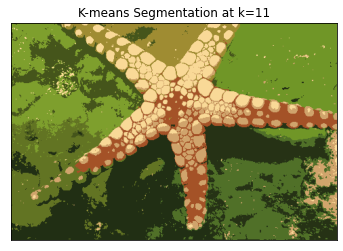

31it [00:01, 26.88it/s]


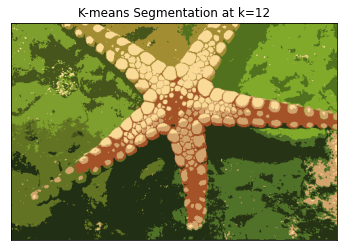

67it [00:02, 23.80it/s]


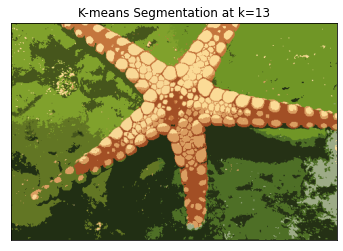

73it [00:03, 23.26it/s]


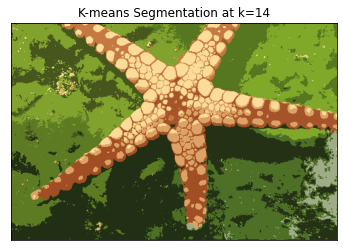

63it [00:02, 21.41it/s]


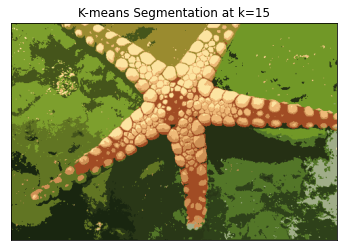

62it [00:03, 20.65it/s]


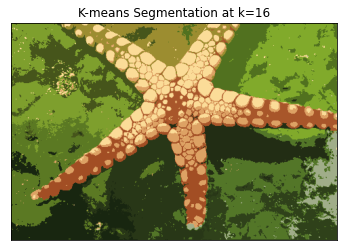

89it [00:04, 19.09it/s]


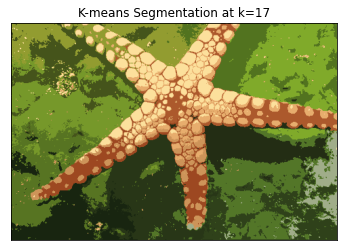

63it [00:03, 17.88it/s]


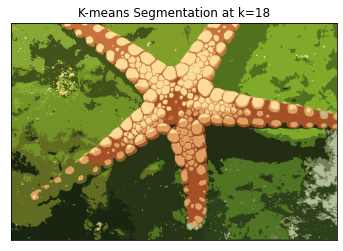

70it [00:03, 17.73it/s]


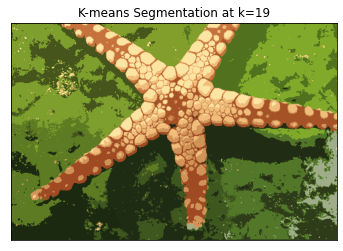

In [200]:
for k in range(2, 20):
    assignments, centroids = k_means(X_indices, k)
    centroids = centroids[:, :3] * color_std + color_mean
    segmentation = np.zeros((assignments.shape[0], 3))
    for i in range(k):
        segmentation[assignments == i] = centroids[i]
    segmentation = segmentation.reshape(*img.shape[:-1], 3)
    plt.imshow(segmentation)
    plt.title(f'K-means Segmentation at k={k}')
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Agglomerative Clustering

In order to avoid the problem of creating a distance matrix which is too big, instead of starting with each pixel being its own cluster, we'll run an initial k-means clustering with a high k values and run agglomerative clustering on those clusters.

In [232]:
class distance_measures:
    @staticmethod
    def minimum(cluster1, cluster2):
        distances = cdist(cluster1, cluster2)
        return distances.min()
    
    @staticmethod
    def maximum(cluster1, cluster2):
        distances = cdist(cluster1, cluster2)
        return distances.max()
    
    @staticmethod
    def mean(cluster1, cluster2):
        centroid1 = np.mean(cluster1, 0)
        centroid2 = np.mean(cluster2, 0)
        return euclidean(centroid1, centroid2)
    
    @staticmethod
    def average(cluster1, cluster2):
        distances = cdist(cluster1, cluster2)
        return distances.mean()

In [281]:
def matrix_argmin(m):
    return np.unravel_index(m.argmin(), m.shape)

def agglomerative_clustering(X, initial_k, distance_measure):
    assignments, _ = k_means(X, initial_k)
    all_assignments = [assignments.copy()]
    
    distances = np.zeros((initial_k, initial_k))
    np.fill_diagonal(distances, np.inf)
    for i in tqdm(range(initial_k), 'Distance Matrix'):
        for j in range(i + 1, initial_k):
            cluster_i = X[assignments == i]
            cluster_j = X[assignments == j]
            distance = distance_measure(cluster_i, cluster_j)
            distances[i, j] = distance
            distances[j, i] = distance
            
    for i in range(k - 1):
        closest1, closest2 = sorted(matrix_argmin(distances))
        assignments[assignments == closest2] = closest1
        break

In [282]:
agglomerative_clustering(X_color[:100], 6, distance_measures.minimum)

4it [00:00, ?it/s]
Distance Matrix: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5832.17it/s]

[[       inf 0.87834001 0.27576834 0.69533059 1.00145954 1.15302852]
 [0.87834001        inf 2.22623478 0.78321184 2.44923443 0.92322925]
 [0.27576834 2.22623478        inf 0.89114424 0.67800004 1.64507094]
 [0.69533059 0.78321184 0.89114424        inf 0.30988429 0.16903514]
 [1.00145954 2.44923443 0.67800004 0.30988429        inf 1.22263451]
 [1.15302852 0.92322925 1.64507094 0.16903514 1.22263451        inf]]
(3, 5)
3 5
